# Takeaways
- Roundtrip works (TODO write tests)
- Write perf
    - No issues
- Read perf
    - 2.1s read_sql_table is fine, but ~7.5s to convert each feat col is too slow for server startup
    - Bottleneck is npy bytes -> np.array
    - But any optimization effort is a waste of time until we nail down how mobile will use the .sqlite payload...
    - TODO Revist once we have an idea how mobile will use search_recs
        - Will it want each array packed as bytes, like this?
        - Or will it want array elements manifested as sql data, e.g. so it can query them using sql?
        - Or something else entirely...?

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [14:26:01.076] [21788] 150 logging_/<module>: {logging_yaml: None}

INFO     [14:26:01.523] [21788]  32 api.server_globals/init

DEBUG    [14:26:01.529] [21788]  75 api.server_globals/load: load_search...

INFO     [14:26:01.834] [21788]  79 api.server_globals/load: load_search (took 0.297s)

DEBUG    [14:26:01.841] [21788]  75 api.server_globals/load: load_xc_meta...

INFO     [14:26:02.173] [21788]  79 api.server_globals/load: load_xc_meta (took 0.325s)

DEBUG    [14:26:02.183] [21788]  75 api.server_globals/load: load_feat_info...

INFO     [14:26:02.192] [21788] 110 api.server_globals/load_feat_info

INFO     [14:26:02.198] [21788]  79 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [14:26:02.204] [21788]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [14:26:02.212] [21788]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
INFO     [12:58:26.969] [37904] 600 api.recs/get_search_recs
INFO     [12:58:26.985] [37904] 118 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[2],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-9481fff
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid', 'refresh': True})

INFO     [14:26:02.440] [21788] 601 api.recs/get_search_recs

INFO     [14:26:02.457] [21788]  69 payloads/df_cache_hybrid: Miss: payloads/search_recs-version[4],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-7993b24

DEBUG    [14:26:02.466] [21788]  72 payloads/df_cache_hybrid: Compute: search_recs [start]

INFO     [14:26:02.475] [21788] 659 api.recs/_compute_search_recs: {len(sg.xc_meta): 35233, countries_k: na, com_names_k: ca, num_recs: null}

DEBUG    [14:26:02.485] [21788] 687 api.recs/recs_featurize_pre_rank: batches (1/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:26:04.560] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:00, 711.22it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:00, 709.29it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 704.62it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 712.40it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████                 | 359/500 [00:00<00:00, 709.97it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▏       | 435/500 [00:00<00:00, 717.19it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 716.78it/s]

INFO     [14:26:05.275] [21788] 925 api.recs/recs_featurize_spectro_bytes: [0.715s]

DEBUG    [14:26:05.283] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#########################################################                          

] |  69% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:05.531] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:26:05.541] [21788] 687 api.recs/recs_featurize_pre_rank: batches (1/71) [3.056s]

DEBUG    [14:26:05.549] [21788] 687 api.recs/recs_featurize_pre_rank: batches (2/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:26:06.075] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   9%|█████▍                                                       | 45/500 [00:00<00:01, 449.65it/s]

rec_spectro_bytes:  19%|███████████▌                                                 | 95/500 [00:00<00:00, 470.99it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:00, 474.84it/s]

rec_spectro_bytes:  39%|███████████████████████▏                                    | 193/500 [00:00<00:00, 477.59it/s]

rec_spectro_bytes:  48%|█████████████████████████████                               | 242/500 [00:00<00:00, 478.70it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 481.48it/s]

rec_spectro_bytes:  68%|████████████████████████████████████████▉                   | 341/500 [00:00<00:00, 482.18it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▌             | 388/500 [00:00<00:00, 480.62it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:00<00:00, 480.84it/s]

rec_spectro_bytes:  97%|██████████████████████████████████████████████████████████  | 484/500 [00:01<00:00, 477.89it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 476.97it/s]

INFO     [14:26:07.141] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.066s]

DEBUG    [14:26:07.148] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###############################################################################    

] |  96% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:07.383] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.235s]

INFO     [14:26:07.392] [21788] 687 api.recs/recs_featurize_pre_rank: batches (2/71) [1.842s]

DEBUG    [14:26:07.399] [21788] 687 api.recs/recs_featurize_pre_rank: batches (3/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:26:07.962] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 342.93it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/500 [00:00<00:01, 359.97it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 357.40it/s]

rec_spectro_bytes:  29%|█████████████████▌                                          | 146/500 [00:00<00:00, 360.08it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:00, 365.43it/s]

rec_spectro_bytes:  44%|██████████████████████████▋                                 | 222/500 [00:00<00:00, 365.62it/s]

rec_spectro_bytes:  52%|███████████████████████████████▎                            | 261/500 [00:00<00:00, 367.68it/s]

rec_spectro_bytes:  61%|████████████████████████████████████▎                       | 303/500 [00:00<00:00, 373.24it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▎                  | 344/500 [00:00<00:00, 377.07it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████▎             | 386/500 [00:01<00:00, 381.00it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 425/500 [00:01<00:00, 379.55it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 379.49it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 376.03it/s]

INFO     [14:26:09.308] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.346s]

DEBUG    [14:26:09.317] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##############################################################                     

] |  75% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:09.565] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:26:09.572] [21788] 687 api.recs/recs_featurize_pre_rank: batches (3/71) [2.173s]

DEBUG    [14:26:09.579] [21788] 687 api.recs/recs_featurize_pre_rank: batches (4/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:10.123] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 365.69it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 370.07it/s]

rec_spectro_bytes:  22%|█████████████▎                                              | 111/500 [00:00<00:01, 364.89it/s]

rec_spectro_bytes:  30%|█████████████████▊                                          | 148/500 [00:00<00:00, 364.38it/s]

rec_spectro_bytes:  37%|██████████████████████▎                                     | 186/500 [00:00<00:00, 367.09it/s]

rec_spectro_bytes:  44%|██████████████████████████▋                                 | 222/500 [00:00<00:00, 364.72it/s]

rec_spectro_bytes:  52%|███████████████████████████████▏                            | 260/500 [00:00<00:00, 365.72it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▍                        | 295/500 [00:00<00:00, 363.61it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▋                    | 331/500 [00:00<00:00, 362.62it/s]

rec_spectro_bytes:  73%|████████████████████████████████████████████                | 367/500 [00:01<00:00, 362.21it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 360.73it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:01<00:00, 360.93it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 475/500 [00:01<00:00, 360.51it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.39it/s]

INFO     [14:26:11.528] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.405s]

DEBUG    [14:26:11.536] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

############################################                                       

] |  53% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:11.783] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:26:11.794] [21788] 687 api.recs/recs_featurize_pre_rank: batches (4/71) [2.215s]

DEBUG    [14:26:11.801] [21788] 687 api.recs/recs_featurize_pre_rank: batches (5/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:12.340] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▋                                                        | 38/500 [00:00<00:01, 373.82it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 369.36it/s]

rec_spectro_bytes:  23%|█████████████▌                                              | 113/500 [00:00<00:01, 371.81it/s]

rec_spectro_bytes:  30%|██████████████████                                          | 150/500 [00:00<00:00, 371.34it/s]

rec_spectro_bytes:  37%|██████████████████████▎                                     | 186/500 [00:00<00:00, 367.99it/s]

rec_spectro_bytes:  45%|███████████████████████████                                 | 226/500 [00:00<00:00, 371.53it/s]

rec_spectro_bytes:  52%|███████████████████████████████▍                            | 262/500 [00:00<00:00, 369.73it/s]

rec_spectro_bytes:  60%|███████████████████████████████████▊                        | 298/500 [00:00<00:00, 368.02it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████                    | 334/500 [00:00<00:00, 366.67it/s]

rec_spectro_bytes:  75%|████████████████████████████████████████████▊               | 373/500 [00:01<00:00, 368.38it/s]

rec_spectro_bytes:  83%|█████████████████████████████████████████████████▌          | 413/500 [00:01<00:00, 370.47it/s]

rec_spectro_bytes:  90%|██████████████████████████████████████████████████████▏     | 452/500 [00:01<00:00, 371.36it/s]

rec_spectro_bytes:  98%|██████████████████████████████████████████████████████████▊ | 490/500 [00:01<00:00, 370.78it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 370.36it/s]

INFO     [14:26:13.706] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.367s]

DEBUG    [14:26:13.714] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:13.959] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:26:13.968] [21788] 687 api.recs/recs_featurize_pre_rank: batches (5/71) [2.167s]

DEBUG    [14:26:13.974] [21788] 687 api.recs/recs_featurize_pre_rank: batches (6/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:14.521] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▋                                                        | 38/500 [00:00<00:01, 376.21it/s]

rec_spectro_bytes:  14%|████████▌                                                    | 70/500 [00:00<00:01, 345.86it/s]

rec_spectro_bytes:  21%|████████████▌                                               | 105/500 [00:00<00:01, 344.69it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 352.71it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 356.57it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 353.25it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 354.87it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▏                        | 293/500 [00:00<00:00, 359.60it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████                    | 334/500 [00:00<00:00, 364.23it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▌               | 371/500 [00:01<00:00, 364.47it/s]

rec_spectro_bytes:  82%|████████████████████████████████████████████████▉           | 408/500 [00:01<00:00, 358.90it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▏      | 443/500 [00:01<00:00, 350.12it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▍  | 479/500 [00:01<00:00, 350.56it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 350.35it/s]

INFO     [14:26:15.964] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.444s]

DEBUG    [14:26:15.973] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:16.214] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.240s]

INFO     [14:26:16.222] [21788] 687 api.recs/recs_featurize_pre_rank: batches (6/71) [2.248s]

DEBUG    [14:26:16.229] [21788] 687 api.recs/recs_featurize_pre_rank: batches (7/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:16.889] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 336.26it/s]

rec_spectro_bytes:  13%|███████▊                                                     | 64/500 [00:00<00:01, 318.16it/s]

rec_spectro_bytes:  20%|████████████▏                                               | 102/500 [00:00<00:01, 336.70it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 353.21it/s]

rec_spectro_bytes:  37%|██████████████████████▎                                     | 186/500 [00:00<00:00, 366.67it/s]

rec_spectro_bytes:  46%|███████████████████████████▍                                | 229/500 [00:00<00:00, 375.80it/s]

rec_spectro_bytes:  54%|████████████████████████████████▌                           | 271/500 [00:00<00:00, 381.55it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▌                      | 313/500 [00:00<00:00, 385.83it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▍                 | 354/500 [00:00<00:00, 388.14it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▋            | 397/500 [00:01<00:00, 391.46it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:01<00:00, 390.73it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████▏  | 477/500 [00:01<00:00, 380.13it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 375.07it/s]

INFO     [14:26:18.240] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.351s]

DEBUG    [14:26:18.249] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:18.493] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:26:18.501] [21788] 687 api.recs/recs_featurize_pre_rank: batches (7/71) [2.272s]

DEBUG    [14:26:18.507] [21788] 687 api.recs/recs_featurize_pre_rank: batches (8/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:19.069] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▋                                                        | 38/500 [00:00<00:01, 372.21it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 353.47it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 357.62it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 362.69it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:00, 365.38it/s]

rec_spectro_bytes:  44%|██████████████████████████▌                                 | 221/500 [00:00<00:00, 364.22it/s]

rec_spectro_bytes:  52%|██████████████████████████████▉                             | 258/500 [00:00<00:00, 363.88it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 362.97it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▍                    | 329/500 [00:00<00:00, 360.88it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▉                | 366/500 [00:01<00:00, 361.13it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 401/500 [00:01<00:00, 359.95it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:01<00:00, 359.27it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▉   | 474/500 [00:01<00:00, 359.75it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.64it/s]

INFO     [14:26:20.479] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.410s]

DEBUG    [14:26:20.486] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##########################################                                         

] |  51% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:20.731] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:26:20.741] [21788] 687 api.recs/recs_featurize_pre_rank: batches (8/71) [2.233s]

DEBUG    [14:26:20.748] [21788] 687 api.recs/recs_featurize_pre_rank: batches (9/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:21.271] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▋                                                        | 38/500 [00:00<00:01, 372.88it/s]

rec_spectro_bytes:  15%|█████████▎                                                   | 76/500 [00:00<00:01, 372.80it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 357.63it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 354.28it/s]

rec_spectro_bytes:  36%|█████████████████████▊                                      | 182/500 [00:00<00:00, 358.91it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 359.02it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 359.44it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 360.25it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▋                    | 331/500 [00:00<00:00, 363.00it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▌               | 371/500 [00:01<00:00, 366.04it/s]

rec_spectro_bytes:  82%|█████████████████████████████████████████████████           | 409/500 [00:01<00:00, 367.07it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▌      | 446/500 [00:01<00:00, 367.00it/s]

rec_spectro_bytes:  97%|█████████████████████████████████████████████████████████▉  | 483/500 [00:01<00:00, 366.98it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 366.98it/s]

INFO     [14:26:22.650] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.378s]

DEBUG    [14:26:22.658] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#############################                                                      

] |  35% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:22.911] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:26:22.921] [21788] 687 api.recs/recs_featurize_pre_rank: batches (9/71) [2.173s]

DEBUG    [14:26:22.928] [21788] 687 api.recs/recs_featurize_pre_rank: batches (10/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:23.464] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 336.83it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 337.31it/s]

rec_spectro_bytes:  21%|████████████▍                                               | 104/500 [00:00<00:01, 343.19it/s]

rec_spectro_bytes:  28%|████████████████▊                                           | 140/500 [00:00<00:01, 346.38it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 176/500 [00:00<00:00, 348.82it/s]

rec_spectro_bytes:  42%|█████████████████████████                                   | 209/500 [00:00<00:00, 345.26it/s]

rec_spectro_bytes:  48%|████████████████████████████▉                               | 241/500 [00:00<00:00, 340.96it/s]

rec_spectro_bytes:  55%|█████████████████████████████████                           | 275/500 [00:00<00:00, 340.23it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▎                      | 311/500 [00:00<00:00, 341.89it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▋                  | 347/500 [00:01<00:00, 343.07it/s]

rec_spectro_bytes:  77%|█████████████████████████████████████████████▉              | 383/500 [00:01<00:00, 344.56it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▏         | 418/500 [00:01<00:00, 342.57it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▍     | 454/500 [00:01<00:00, 343.27it/s]

rec_spectro_bytes:  98%|██████████████████████████████████████████████████████████▋ | 489/500 [00:01<00:00, 343.64it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 342.95it/s]

INFO     [14:26:24.940] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.476s]

DEBUG    [14:26:24.948] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:25.197] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:26:25.206] [21788] 687 api.recs/recs_featurize_pre_rank: batches (10/71) [2.278s]

DEBUG    [14:26:25.213] [21788] 687 api.recs/recs_featurize_pre_rank: batches (11/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:25.752] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 353.92it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 354.24it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 354.23it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 355.53it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 356.73it/s]

rec_spectro_bytes:  43%|██████████████████████████                                  | 217/500 [00:00<00:00, 355.83it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 251/500 [00:00<00:00, 353.46it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▌                         | 288/500 [00:00<00:00, 355.32it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▉                     | 324/500 [00:00<00:00, 355.56it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████                 | 359/500 [00:01<00:00, 354.41it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▎            | 394/500 [00:01<00:00, 352.10it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▋        | 431/500 [00:01<00:00, 352.86it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▏   | 468/500 [00:01<00:00, 353.48it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.42it/s]

INFO     [14:26:27.186] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.434s]

DEBUG    [14:26:27.193] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##########################################                                         

] |  51% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:27.433] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.240s]

INFO     [14:26:27.441] [21788] 687 api.recs/recs_featurize_pre_rank: batches (11/71) [2.229s]

DEBUG    [14:26:27.448] [21788] 687 api.recs/recs_featurize_pre_rank: batches (12/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:26:28.146] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 328.40it/s]

rec_spectro_bytes:  13%|███████▉                                                     | 65/500 [00:00<00:01, 321.28it/s]

rec_spectro_bytes:  20%|████████████                                                | 101/500 [00:00<00:01, 332.94it/s]

rec_spectro_bytes:  27%|████████████████▍                                           | 137/500 [00:00<00:01, 337.41it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 344.77it/s]

rec_spectro_bytes:  42%|█████████████████████████▎                                  | 211/500 [00:00<00:00, 347.04it/s]

rec_spectro_bytes:  49%|█████████████████████████████▋                              | 247/500 [00:00<00:00, 348.85it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▊                          | 282/500 [00:00<00:00, 348.94it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▎                     | 319/500 [00:00<00:00, 350.44it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▋                 | 356/500 [00:01<00:00, 352.15it/s]

rec_spectro_bytes:  78%|███████████████████████████████████████████████             | 392/500 [00:01<00:00, 351.46it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▍        | 429/500 [00:01<00:00, 352.29it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▉    | 466/500 [00:01<00:00, 353.32it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 354.40it/s]

INFO     [14:26:29.573] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.427s]

DEBUG    [14:26:29.581] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:29.821] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.240s]

INFO     [14:26:29.831] [21788] 687 api.recs/recs_featurize_pre_rank: batches (12/71) [2.383s]

DEBUG    [14:26:29.838] [21788] 687 api.recs/recs_featurize_pre_rank: batches (13/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:30.371] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 363.08it/s]

rec_spectro_bytes:  15%|█████████                                                    | 74/500 [00:00<00:01, 365.14it/s]

rec_spectro_bytes:  22%|█████████████▍                                              | 112/500 [00:00<00:01, 369.21it/s]

rec_spectro_bytes:  30%|██████████████████                                          | 151/500 [00:00<00:00, 372.36it/s]

rec_spectro_bytes:  38%|██████████████████████▊                                     | 190/500 [00:00<00:00, 375.43it/s]

rec_spectro_bytes:  46%|███████████████████████████▍                                | 229/500 [00:00<00:00, 376.63it/s]

rec_spectro_bytes:  53%|████████████████████████████████                            | 267/500 [00:00<00:00, 376.98it/s]

rec_spectro_bytes:  61%|████████████████████████████████████▌                       | 305/500 [00:00<00:00, 376.27it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▎                  | 344/500 [00:00<00:00, 377.47it/s]

rec_spectro_bytes:  76%|█████████████████████████████████████████████▊              | 382/500 [00:01<00:00, 377.22it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▍         | 420/500 [00:01<00:00, 376.70it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████     | 459/500 [00:01<00:00, 377.43it/s]

rec_spectro_bytes: 100%|███████████████████████████████████████████████████████████▊| 498/500 [00:01<00:00, 377.95it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 377.27it/s]

INFO     [14:26:31.715] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.343s]

DEBUG    [14:26:31.723] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#####################################                                              

] |  44% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:31.971] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:26:31.985] [21788] 687 api.recs/recs_featurize_pre_rank: batches (13/71) [2.147s]

DEBUG    [14:26:31.994] [21788] 687 api.recs/recs_featurize_pre_rank: batches (14/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:32.545] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   5%|███                                                          | 25/500 [00:00<00:01, 249.44it/s]

rec_spectro_bytes:  12%|███████▏                                                     | 59/500 [00:00<00:01, 291.45it/s]

rec_spectro_bytes:  18%|███████████▏                                                 | 92/500 [00:00<00:01, 299.45it/s]

rec_spectro_bytes:  26%|███████████████▍                                            | 129/500 [00:00<00:01, 316.74it/s]

rec_spectro_bytes:  34%|████████████████████▏                                       | 168/500 [00:00<00:01, 329.46it/s]

rec_spectro_bytes:  41%|████████████████████████▌                                   | 205/500 [00:00<00:00, 335.65it/s]

rec_spectro_bytes:  48%|████████████████████████████▉                               | 241/500 [00:00<00:00, 338.58it/s]

rec_spectro_bytes:  55%|█████████████████████████████████▏                          | 277/500 [00:00<00:00, 341.14it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▌                      | 313/500 [00:00<00:00, 342.49it/s]

rec_spectro_bytes:  70%|██████████████████████████████████████████                  | 350/500 [00:01<00:00, 344.48it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▊             | 390/500 [00:01<00:00, 349.18it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████▏        | 427/500 [00:01<00:00, 348.83it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 350.15it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 351.30it/s]

INFO     [14:26:33.987] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.442s]

DEBUG    [14:26:33.995] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################                                                

] |  42% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:34.244] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:26:34.253] [21788] 687 api.recs/recs_featurize_pre_rank: batches (14/71) [2.259s]

DEBUG    [14:26:34.259] [21788] 687 api.recs/recs_featurize_pre_rank: batches (15/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:34.815] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 353.56it/s]

rec_spectro_bytes:  13%|████████▏                                                    | 67/500 [00:00<00:01, 328.84it/s]

rec_spectro_bytes:  21%|████████████▌                                               | 105/500 [00:00<00:01, 343.39it/s]

rec_spectro_bytes:  28%|█████████████████                                           | 142/500 [00:00<00:01, 349.03it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 355.48it/s]

rec_spectro_bytes:  43%|██████████████████████████                                  | 217/500 [00:00<00:00, 355.58it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 356.18it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 356.89it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▍                    | 329/500 [00:00<00:00, 359.50it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▉                | 366/500 [00:01<00:00, 360.47it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▍           | 404/500 [00:01<00:00, 361.54it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▉       | 441/500 [00:01<00:00, 361.84it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▎  | 478/500 [00:01<00:00, 361.18it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 362.19it/s]

INFO     [14:26:36.210] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.395s]

DEBUG    [14:26:36.219] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

################################################                                   

] |  58% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:36.468] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:26:36.477] [21788] 687 api.recs/recs_featurize_pre_rank: batches (15/71) [2.218s]

DEBUG    [14:26:36.485] [21788] 687 api.recs/recs_featurize_pre_rank: batches (16/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:37.030] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 332.54it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 338.50it/s]

rec_spectro_bytes:  21%|████████████▍                                               | 104/500 [00:00<00:01, 341.51it/s]

rec_spectro_bytes:  28%|████████████████▊                                           | 140/500 [00:00<00:01, 343.90it/s]

rec_spectro_bytes:  35%|████████████████████▊                                       | 173/500 [00:00<00:00, 339.35it/s]

rec_spectro_bytes:  41%|████████████████████████▊                                   | 207/500 [00:00<00:00, 338.88it/s]

rec_spectro_bytes:  49%|█████████████████████████████▍                              | 245/500 [00:00<00:00, 343.40it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▎                          | 278/500 [00:00<00:00, 341.55it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▏                     | 318/500 [00:00<00:00, 347.39it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▎                 | 353/500 [00:01<00:00, 347.06it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▋             | 389/500 [00:01<00:00, 348.17it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 425/500 [00:01<00:00, 348.81it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▍    | 462/500 [00:01<00:00, 349.99it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 352.07it/s]

INFO     [14:26:38.467] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.438s]

DEBUG    [14:26:38.474] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################                                                

] |  42% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:38.727] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:26:38.736] [21788] 687 api.recs/recs_featurize_pre_rank: batches (16/71) [2.251s]

DEBUG    [14:26:38.743] [21788] 687 api.recs/recs_featurize_pre_rank: batches (17/71) [start]

f_preds: [

] |   0% (499) |  0.0s

f_preds: [

] |   0% (499) |  0.1s

f_preds: [

] |   0% (499) |  0.2s

f_preds: [

#######################################################################################

] | 100% (499) |  0.3s

DEBUG    [14:26:39.275] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/499 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/499 [00:00<00:01, 328.07it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/499 [00:00<00:01, 338.51it/s]

rec_spectro_bytes:  21%|████████████▍                                               | 103/499 [00:00<00:01, 336.70it/s]

rec_spectro_bytes:  25%|███████████████▎                                            | 127/499 [00:00<00:01, 309.28it/s]

rec_spectro_bytes:  30%|██████████████████                                          | 150/499 [00:00<00:01, 292.58it/s]

rec_spectro_bytes:  35%|████████████████████▊                                       | 173/499 [00:00<00:01, 272.00it/s]

rec_spectro_bytes:  39%|███████████████████████▍                                    | 195/499 [00:00<00:01, 264.91it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/499 [00:00<00:01, 259.66it/s]

rec_spectro_bytes:  48%|████████████████████████████▉                               | 241/499 [00:00<00:01, 255.76it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▍                          | 278/499 [00:01<00:00, 266.60it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▌                      | 312/499 [00:01<00:00, 272.93it/s]

rec_spectro_bytes:  70%|█████████████████████████████████████████▋                  | 347/499 [00:01<00:00, 278.91it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████▎             | 385/499 [00:01<00:00, 286.00it/s]

rec_spectro_bytes:  85%|██████████████████████████████████████████████████▋         | 422/499 [00:01<00:00, 291.48it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▊     | 456/499 [00:01<00:00, 294.26it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▏| 492/499 [00:01<00:00, 298.07it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 499/499 [00:01<00:00, 298.19it/s]

INFO     [14:26:40.967] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.692s]

DEBUG    [14:26:40.974] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (499) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (499) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (499) |  0.2s

INFO     [14:26:41.219] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.244s]

INFO     [14:26:41.228] [21788] 687 api.recs/recs_featurize_pre_rank: batches (17/71) [2.485s]

DEBUG    [14:26:41.234] [21788] 687 api.recs/recs_featurize_pre_rank: batches (18/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:26:41.920] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▊                                                         | 31/500 [00:00<00:01, 268.01it/s]

rec_spectro_bytes:  12%|███████▎                                                     | 60/500 [00:00<00:01, 277.49it/s]

rec_spectro_bytes:  19%|███████████▋                                                 | 96/500 [00:00<00:01, 302.95it/s]

rec_spectro_bytes:  27%|███████████████▉                                            | 133/500 [00:00<00:01, 317.68it/s]

rec_spectro_bytes:  34%|████████████████████▎                                       | 169/500 [00:00<00:01, 325.70it/s]

rec_spectro_bytes:  41%|████████████████████████▌                                   | 205/500 [00:00<00:00, 330.09it/s]

rec_spectro_bytes:  49%|█████████████████████████████▍                              | 245/500 [00:00<00:00, 338.91it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▋                          | 281/500 [00:00<00:00, 340.25it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▉                      | 316/500 [00:00<00:00, 340.83it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▎                 | 353/500 [00:01<00:00, 343.05it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▊             | 390/500 [00:01<00:00, 345.26it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 426/500 [00:01<00:00, 345.64it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 347.82it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 348.25it/s]

INFO     [14:26:43.375] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.455s]

DEBUG    [14:26:43.383] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################                                               

] |  43% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:43.630] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.247s]

INFO     [14:26:43.639] [21788] 687 api.recs/recs_featurize_pre_rank: batches (18/71) [2.405s]

DEBUG    [14:26:43.645] [21788] 687 api.recs/recs_featurize_pre_rank: batches (19/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:44.182] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 348.58it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 352.16it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 349.18it/s]

rec_spectro_bytes:  28%|████████████████▋                                           | 139/500 [00:00<00:01, 343.18it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 345.15it/s]

rec_spectro_bytes:  42%|█████████████████████████                                   | 209/500 [00:00<00:00, 343.33it/s]

rec_spectro_bytes:  49%|█████████████████████████████▎                              | 244/500 [00:00<00:00, 343.35it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▍                          | 279/500 [00:00<00:00, 343.18it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▋                      | 314/500 [00:00<00:00, 343.18it/s]

rec_spectro_bytes:  70%|█████████████████████████████████████████▉                  | 349/500 [00:01<00:00, 343.49it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████▎             | 386/500 [00:01<00:00, 345.14it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▋         | 422/500 [00:01<00:00, 346.17it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▊     | 457/500 [00:01<00:00, 346.29it/s]

rec_spectro_bytes:  98%|███████████████████████████████████████████████████████████ | 492/500 [00:01<00:00, 344.51it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 344.05it/s]

INFO     [14:26:45.652] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.470s]

DEBUG    [14:26:45.660] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################                                               

] |  43% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:45.909] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:26:45.918] [21788] 687 api.recs/recs_featurize_pre_rank: batches (19/71) [2.273s]

DEBUG    [14:26:45.924] [21788] 687 api.recs/recs_featurize_pre_rank: batches (20/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:26:46.476] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 353.66it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 351.49it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 355.89it/s]

rec_spectro_bytes:  29%|█████████████████▍                                          | 145/500 [00:00<00:00, 358.69it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 358.05it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 359.64it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 360.25it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 358.20it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▎                    | 328/500 [00:00<00:00, 359.90it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 358.15it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 400/500 [00:01<00:00, 358.92it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:01<00:00, 359.07it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▊   | 473/500 [00:01<00:00, 358.45it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.09it/s]

INFO     [14:26:47.886] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.410s]

DEBUG    [14:26:47.894] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:48.147] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:26:48.155] [21788] 687 api.recs/recs_featurize_pre_rank: batches (20/71) [2.231s]

DEBUG    [14:26:48.161] [21788] 687 api.recs/recs_featurize_pre_rank: batches (21/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:48.710] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 359.21it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 347.99it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 347.58it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 352.06it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 355.53it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 357.51it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 357.83it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▋                         | 289/500 [00:00<00:00, 353.75it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████▏                    | 327/500 [00:00<00:00, 355.83it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 355.94it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 400/500 [00:01<00:00, 357.08it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:01<00:00, 359.21it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 358.79it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 358.56it/s]

INFO     [14:26:50.122] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.412s]

DEBUG    [14:26:50.130] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:50.382] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.252s]

INFO     [14:26:50.392] [21788] 687 api.recs/recs_featurize_pre_rank: batches (21/71) [2.231s]

DEBUG    [14:26:50.400] [21788] 687 api.recs/recs_featurize_pre_rank: batches (22/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:26:50.944] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 343.28it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 353.05it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 358.31it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 361.87it/s]

rec_spectro_bytes:  37%|█████████████████████▉                                      | 183/500 [00:00<00:00, 361.06it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 357.82it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 358.68it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 359.31it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▎                    | 328/500 [00:00<00:00, 358.84it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▊                | 365/500 [00:01<00:00, 359.47it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▍           | 404/500 [00:01<00:00, 361.63it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▉       | 441/500 [00:01<00:00, 360.96it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▎  | 478/500 [00:01<00:00, 361.34it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 361.04it/s]

INFO     [14:26:52.346] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.402s]

DEBUG    [14:26:52.353] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################                                                 

] |  41% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:52.599] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:26:52.608] [21788] 687 api.recs/recs_featurize_pre_rank: batches (22/71) [2.208s]

DEBUG    [14:26:52.613] [21788] 687 api.recs/recs_featurize_pre_rank: batches (23/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:26:53.164] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 349.71it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 355.75it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 358.08it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 361.32it/s]

rec_spectro_bytes:  37%|██████████████████████                                      | 184/500 [00:00<00:00, 362.90it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 361.78it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 361.72it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 360.20it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████▏                    | 327/500 [00:00<00:00, 358.30it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▎                | 361/500 [00:01<00:00, 355.35it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▋            | 397/500 [00:01<00:00, 355.22it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████        | 434/500 [00:01<00:00, 356.00it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▌   | 471/500 [00:01<00:00, 356.48it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.91it/s]

INFO     [14:26:54.594] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.429s]

DEBUG    [14:26:54.601] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:54.850] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:26:54.860] [21788] 687 api.recs/recs_featurize_pre_rank: batches (23/71) [2.247s]

DEBUG    [14:26:54.868] [21788] 687 api.recs/recs_featurize_pre_rank: batches (24/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:26:55.543] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   5%|██▊                                                          | 23/500 [00:00<00:02, 228.68it/s]

rec_spectro_bytes:   9%|█████▏                                                       | 43/500 [00:00<00:02, 212.67it/s]

rec_spectro_bytes:  13%|███████▉                                                     | 65/500 [00:00<00:02, 211.59it/s]

rec_spectro_bytes:  18%|██████████▋                                                  | 88/500 [00:00<00:01, 215.14it/s]

rec_spectro_bytes:  22%|█████████████▏                                              | 110/500 [00:00<00:01, 214.98it/s]

rec_spectro_bytes:  26%|███████████████▋                                            | 131/500 [00:00<00:01, 214.04it/s]

rec_spectro_bytes:  31%|██████████████████▋                                         | 156/500 [00:00<00:01, 218.11it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:01, 218.49it/s]

rec_spectro_bytes:  40%|████████████████████████                                    | 200/500 [00:00<00:01, 216.18it/s]

rec_spectro_bytes:  44%|██████████████████████████▌                                 | 221/500 [00:01<00:01, 215.41it/s]

rec_spectro_bytes:  49%|█████████████████████████████▎                              | 244/500 [00:01<00:01, 216.38it/s]

rec_spectro_bytes:  54%|████████████████████████████████▌                           | 271/500 [00:01<00:01, 220.22it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:01<00:00, 219.46it/s]

rec_spectro_bytes:  63%|██████████████████████████████████████                      | 317/500 [00:01<00:00, 218.48it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▏                  | 343/500 [00:01<00:00, 221.02it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▎               | 369/500 [00:01<00:00, 223.06it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▎            | 394/500 [00:01<00:00, 224.29it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▎         | 419/500 [00:01<00:00, 225.59it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▎      | 444/500 [00:01<00:00, 226.57it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▎   | 469/500 [00:02<00:00, 227.48it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▎| 494/500 [00:02<00:00, 225.85it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 226.12it/s]

INFO     [14:26:57.771] [21788] 925 api.recs/recs_featurize_spectro_bytes: [2.228s]

DEBUG    [14:26:57.778] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################                                                 

] |  41% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:26:58.022] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:26:58.032] [21788] 687 api.recs/recs_featurize_pre_rank: batches (24/71) [3.164s]

DEBUG    [14:26:58.039] [21788] 687 api.recs/recs_featurize_pre_rank: batches (25/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:26:58.591] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 332.17it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 337.77it/s]

rec_spectro_bytes:  21%|████████████▎                                               | 103/500 [00:00<00:01, 335.88it/s]

rec_spectro_bytes:  28%|████████████████▋                                           | 139/500 [00:00<00:01, 340.50it/s]

rec_spectro_bytes:  35%|████████████████████▊                                       | 173/500 [00:00<00:00, 339.86it/s]

rec_spectro_bytes:  42%|█████████████████████████▏                                  | 210/500 [00:00<00:00, 344.10it/s]

rec_spectro_bytes:  49%|█████████████████████████████▏                              | 243/500 [00:00<00:00, 342.07it/s]

rec_spectro_bytes:  55%|█████████████████████████████████▏                          | 277/500 [00:00<00:00, 340.70it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▍                      | 312/500 [00:00<00:00, 341.53it/s]

rec_spectro_bytes:  70%|█████████████████████████████████████████▊                  | 348/500 [00:01<00:00, 342.79it/s]

rec_spectro_bytes:  77%|█████████████████████████████████████████████▉              | 383/500 [00:01<00:00, 343.37it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▍         | 420/500 [00:01<00:00, 344.83it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▋     | 456/500 [00:01<00:00, 345.21it/s]

rec_spectro_bytes:  98%|██████████████████████████████████████████████████████████▉ | 491/500 [00:01<00:00, 343.80it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 343.16it/s]

INFO     [14:27:00.066] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.475s]

DEBUG    [14:27:00.075] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################                                            

] |  47% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:00.332] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.257s]

INFO     [14:27:00.340] [21788] 687 api.recs/recs_featurize_pre_rank: batches (25/71) [2.302s]

DEBUG    [14:27:00.346] [21788] 687 api.recs/recs_featurize_pre_rank: batches (26/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:27:00.900] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 341.99it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/500 [00:00<00:01, 358.61it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 354.61it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 350.79it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 351.75it/s]

rec_spectro_bytes:  43%|█████████████████████████▋                                  | 214/500 [00:00<00:00, 350.93it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 251/500 [00:00<00:00, 353.33it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 352.81it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 351.98it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▋                 | 356/500 [00:01<00:00, 350.72it/s]

rec_spectro_bytes:  78%|███████████████████████████████████████████████             | 392/500 [00:01<00:00, 350.96it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████▏        | 427/500 [00:01<00:00, 350.14it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▍    | 462/500 [00:01<00:00, 346.37it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▌| 496/500 [00:01<00:00, 321.45it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 321.34it/s]

INFO     [14:27:02.472] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.572s]

DEBUG    [14:27:02.481] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################                                                 

] |  41% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:02.733] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:27:02.742] [21788] 687 api.recs/recs_featurize_pre_rank: batches (26/71) [2.396s]

DEBUG    [14:27:02.750] [21788] 687 api.recs/recs_featurize_pre_rank: batches (27/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:03.301] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 352.85it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 354.96it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 351.89it/s]

rec_spectro_bytes:  29%|█████████████████▍                                          | 145/500 [00:00<00:00, 357.16it/s]

rec_spectro_bytes:  36%|█████████████████████▊                                      | 182/500 [00:00<00:00, 358.85it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 358.98it/s]

rec_spectro_bytes:  51%|██████████████████████████████▍                             | 254/500 [00:00<00:00, 357.94it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▋                         | 289/500 [00:00<00:00, 356.78it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████                     | 325/500 [00:00<00:00, 356.53it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 358.35it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 400/500 [00:01<00:00, 358.84it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:01<00:00, 359.16it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▊   | 473/500 [00:01<00:00, 358.75it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.41it/s]

INFO     [14:27:04.727] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.425s]

DEBUG    [14:27:04.735] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################                                                 

] |  41% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:04.983] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:27:04.992] [21788] 687 api.recs/recs_featurize_pre_rank: batches (27/71) [2.242s]

DEBUG    [14:27:04.999] [21788] 687 api.recs/recs_featurize_pre_rank: batches (28/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:05.557] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 326.18it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 336.79it/s]

rec_spectro_bytes:  20%|████████████                                                | 101/500 [00:00<00:01, 333.81it/s]

rec_spectro_bytes:  27%|████████████████▍                                           | 137/500 [00:00<00:01, 338.60it/s]

rec_spectro_bytes:  35%|████████████████████▊                                       | 173/500 [00:00<00:00, 341.86it/s]

rec_spectro_bytes:  42%|████████████████████████▉                                   | 208/500 [00:00<00:00, 342.03it/s]

rec_spectro_bytes:  49%|█████████████████████████████▍                              | 245/500 [00:00<00:00, 345.82it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▍                          | 279/500 [00:00<00:00, 344.96it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▉                      | 316/500 [00:00<00:00, 347.23it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▎                 | 353/500 [00:01<00:00, 349.00it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▊             | 390/500 [00:01<00:00, 350.40it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████▏        | 427/500 [00:01<00:00, 351.73it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 353.03it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 352.04it/s]

INFO     [14:27:06.995] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.438s]

DEBUG    [14:27:07.002] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################                                               

] |  43% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:07.253] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.251s]

INFO     [14:27:07.264] [21788] 687 api.recs/recs_featurize_pre_rank: batches (28/71) [2.265s]

DEBUG    [14:27:07.271] [21788] 687 api.recs/recs_featurize_pre_rank: batches (29/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:07.818] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 346.44it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 350.50it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 357.87it/s]

rec_spectro_bytes:  29%|█████████████████▌                                          | 146/500 [00:00<00:00, 360.35it/s]

rec_spectro_bytes:  37%|█████████████████████▉                                      | 183/500 [00:00<00:00, 360.58it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 360.46it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 356.05it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 357.22it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████▏                    | 327/500 [00:00<00:00, 358.14it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▍                | 362/500 [00:01<00:00, 357.10it/s]

rec_spectro_bytes:  80%|███████████████████████████████████████████████▊            | 398/500 [00:01<00:00, 356.57it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████        | 434/500 [00:01<00:00, 356.28it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▋   | 472/500 [00:01<00:00, 357.85it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.16it/s]

INFO     [14:27:09.244] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.426s]

DEBUG    [14:27:09.253] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#####################################                                              

] |  44% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:09.497] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.244s]

INFO     [14:27:09.507] [21788] 687 api.recs/recs_featurize_pre_rank: batches (29/71) [2.236s]

DEBUG    [14:27:09.514] [21788] 687 api.recs/recs_featurize_pre_rank: batches (30/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:27:10.218] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▉                                                         | 32/500 [00:00<00:01, 311.47it/s]

rec_spectro_bytes:  13%|████████                                                     | 66/500 [00:00<00:01, 322.16it/s]

rec_spectro_bytes:  20%|████████████▏                                               | 102/500 [00:00<00:01, 331.51it/s]

rec_spectro_bytes:  28%|████████████████▋                                           | 139/500 [00:00<00:01, 340.35it/s]

rec_spectro_bytes:  35%|████████████████████▊                                       | 173/500 [00:00<00:00, 340.13it/s]

rec_spectro_bytes:  42%|█████████████████████████▏                                  | 210/500 [00:00<00:00, 343.98it/s]

rec_spectro_bytes:  49%|█████████████████████████████▌                              | 246/500 [00:00<00:00, 345.04it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▌                          | 280/500 [00:00<00:00, 344.27it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▉                      | 316/500 [00:00<00:00, 345.54it/s]

rec_spectro_bytes:  70%|██████████████████████████████████████████▏                 | 352/500 [00:01<00:00, 345.98it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████▍             | 387/500 [00:01<00:00, 346.08it/s]

rec_spectro_bytes:  85%|██████████████████████████████████████████████████▉         | 424/500 [00:01<00:00, 347.56it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████     | 459/500 [00:01<00:00, 347.49it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▌| 496/500 [00:01<00:00, 348.75it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 348.12it/s]

INFO     [14:27:11.672] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.453s]

DEBUG    [14:27:11.679] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#########################################                                          

] |  50% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:11.933] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.254s]

INFO     [14:27:11.942] [21788] 687 api.recs/recs_featurize_pre_rank: batches (30/71) [2.428s]

DEBUG    [14:27:11.948] [21788] 687 api.recs/recs_featurize_pre_rank: batches (31/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:27:12.522] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 348.77it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 350.11it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 349.95it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 353.52it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 352.64it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 348.95it/s]

rec_spectro_bytes:  50%|█████████████████████████████▉                              | 249/500 [00:00<00:00, 349.69it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▊                          | 282/500 [00:00<00:00, 346.38it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▏                     | 318/500 [00:00<00:00, 347.79it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▍                 | 354/500 [00:01<00:00, 348.98it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▉             | 391/500 [00:01<00:00, 350.55it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 426/500 [00:01<00:00, 349.52it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 351.11it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 351.16it/s]

INFO     [14:27:13.962] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.440s]

DEBUG    [14:27:13.969] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################                                               

] |  43% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:14.222] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:27:14.232] [21788] 687 api.recs/recs_featurize_pre_rank: batches (31/71) [2.284s]

DEBUG    [14:27:14.240] [21788] 687 api.recs/recs_featurize_pre_rank: batches (32/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:14.767] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 355.93it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 352.78it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 356.88it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:00, 356.57it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 354.68it/s]

rec_spectro_bytes:  43%|██████████████████████████                                  | 217/500 [00:00<00:00, 358.36it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 358.04it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▋                         | 289/500 [00:00<00:00, 357.68it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████                     | 326/500 [00:00<00:00, 358.58it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▎                | 361/500 [00:01<00:00, 355.77it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▋            | 397/500 [00:01<00:00, 355.35it/s]

rec_spectro_bytes:  87%|███████████████████████████████████████████████████▉        | 433/500 [00:01<00:00, 355.33it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▍   | 470/500 [00:01<00:00, 356.41it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 356.82it/s]

INFO     [14:27:16.185] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.418s]

DEBUG    [14:27:16.193] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################                                            

] |  47% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:16.450] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.257s]

INFO     [14:27:16.460] [21788] 687 api.recs/recs_featurize_pre_rank: batches (32/71) [2.220s]

DEBUG    [14:27:16.467] [21788] 687 api.recs/recs_featurize_pre_rank: batches (33/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:16.995] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 337.15it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 358.19it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 360.02it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 364.70it/s]

rec_spectro_bytes:  37%|██████████████████████                                      | 184/500 [00:00<00:00, 364.05it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 362.74it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 363.12it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▉                         | 291/500 [00:00<00:00, 359.58it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████▏                    | 327/500 [00:00<00:00, 358.23it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▋                | 364/500 [00:01<00:00, 359.10it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 360.38it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▊       | 440/500 [00:01<00:00, 361.32it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████▏  | 477/500 [00:01<00:00, 361.55it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 361.30it/s]

INFO     [14:27:18.397] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.402s]

DEBUG    [14:27:18.405] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#########################################                                          

] |  50% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:18.648] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:27:18.658] [21788] 687 api.recs/recs_featurize_pre_rank: batches (33/71) [2.192s]

DEBUG    [14:27:18.665] [21788] 687 api.recs/recs_featurize_pre_rank: batches (34/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:19.196] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 336.45it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 352.60it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 354.83it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:00, 358.50it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 359.19it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 360.87it/s]

rec_spectro_bytes:  51%|██████████████████████████████▋                             | 256/500 [00:00<00:00, 363.12it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 364.35it/s]

rec_spectro_bytes:  67%|███████████████████████████████████████▉                    | 333/500 [00:00<00:00, 366.29it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▍               | 370/500 [00:01<00:00, 366.36it/s]

rec_spectro_bytes:  82%|█████████████████████████████████████████████████           | 409/500 [00:01<00:00, 367.62it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▌      | 446/500 [00:01<00:00, 367.54it/s]

rec_spectro_bytes:  97%|█████████████████████████████████████████████████████████▉  | 483/500 [00:01<00:00, 367.48it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 367.26it/s]

INFO     [14:27:20.576] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.379s]

DEBUG    [14:27:20.583] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:20.832] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:27:20.841] [21788] 687 api.recs/recs_featurize_pre_rank: batches (34/71) [2.176s]

DEBUG    [14:27:20.848] [21788] 687 api.recs/recs_featurize_pre_rank: batches (35/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:21.396] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 337.17it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 358.07it/s]

rec_spectro_bytes:  22%|█████████████▏                                              | 110/500 [00:00<00:01, 365.05it/s]

rec_spectro_bytes:  29%|█████████████████▍                                          | 145/500 [00:00<00:00, 358.74it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 358.66it/s]

rec_spectro_bytes:  44%|██████████████████████████▎                                 | 219/500 [00:00<00:00, 359.76it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 358.51it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▉                         | 291/500 [00:00<00:00, 358.35it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▎                    | 328/500 [00:00<00:00, 359.32it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 357.41it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 401/500 [00:01<00:00, 358.62it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:01<00:00, 360.01it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 360.32it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.36it/s]

INFO     [14:27:22.801] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.405s]

DEBUG    [14:27:22.810] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################################                                 

] |  60% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:23.054] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.244s]

INFO     [14:27:23.063] [21788] 687 api.recs/recs_featurize_pre_rank: batches (35/71) [2.215s]

DEBUG    [14:27:23.070] [21788] 687 api.recs/recs_featurize_pre_rank: batches (36/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:23.610] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 358.22it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 354.59it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 359.18it/s]

rec_spectro_bytes:  29%|█████████████████▍                                          | 145/500 [00:00<00:00, 357.59it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 353.08it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 355.07it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 356.63it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 354.31it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▊                     | 323/500 [00:00<00:00, 354.81it/s]

rec_spectro_bytes:  72%|██████████████████████████████████████████▉                 | 358/500 [00:01<00:00, 353.41it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▏            | 393/500 [00:01<00:00, 352.67it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▌        | 430/500 [00:01<00:00, 353.59it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▉    | 466/500 [00:01<00:00, 353.71it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.13it/s]

INFO     [14:27:25.043] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.433s]

DEBUG    [14:27:25.051] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##########################################                                         

] |  51% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:25.429] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.378s]

INFO     [14:27:25.437] [21788] 687 api.recs/recs_featurize_pre_rank: batches (36/71) [2.367s]

DEBUG    [14:27:25.443] [21788] 687 api.recs/recs_featurize_pre_rank: batches (37/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:25.988] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 340.42it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 339.80it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 349.18it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 354.24it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 354.18it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 355.63it/s]

rec_spectro_bytes:  51%|██████████████████████████████▍                             | 254/500 [00:00<00:00, 357.97it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 360.58it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 362.27it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▉                | 366/500 [00:01<00:00, 360.13it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▎           | 403/500 [00:01<00:00, 360.53it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▉       | 441/500 [00:01<00:00, 361.87it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▎  | 478/500 [00:01<00:00, 362.00it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 361.41it/s]

INFO     [14:27:27.389] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.401s]

DEBUG    [14:27:27.397] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##########################################                                         

] |  51% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:27.640] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:27:27.649] [21788] 687 api.recs/recs_featurize_pre_rank: batches (37/71) [2.206s]

DEBUG    [14:27:27.657] [21788] 687 api.recs/recs_featurize_pre_rank: batches (38/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:28.198] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 354.05it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/500 [00:00<00:01, 361.39it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 358.10it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 355.58it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 358.04it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 362.11it/s]

rec_spectro_bytes:  52%|███████████████████████████████                             | 259/500 [00:00<00:00, 365.18it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 362.29it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▋                    | 331/500 [00:00<00:00, 362.61it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▎               | 369/500 [00:01<00:00, 363.65it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▊           | 407/500 [00:01<00:00, 364.56it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▌      | 446/500 [00:01<00:00, 366.25it/s]

rec_spectro_bytes:  97%|██████████████████████████████████████████████████████████  | 484/500 [00:01<00:00, 366.95it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 366.70it/s]

INFO     [14:27:29.579] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.380s]

DEBUG    [14:27:29.587] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:29.832] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:27:29.840] [21788] 687 api.recs/recs_featurize_pre_rank: batches (38/71) [2.183s]

DEBUG    [14:27:29.847] [21788] 687 api.recs/recs_featurize_pre_rank: batches (39/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:30.392] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 367.33it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 369.27it/s]

rec_spectro_bytes:  23%|█████████████▌                                              | 113/500 [00:00<00:01, 369.74it/s]

rec_spectro_bytes:  30%|█████████████████▉                                          | 149/500 [00:00<00:00, 366.99it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:00, 365.51it/s]

rec_spectro_bytes:  44%|██████████████████████████▋                                 | 222/500 [00:00<00:00, 365.51it/s]

rec_spectro_bytes:  52%|███████████████████████████████                             | 259/500 [00:00<00:00, 365.39it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▏                        | 293/500 [00:00<00:00, 361.90it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▊                    | 332/500 [00:00<00:00, 364.86it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▌               | 371/500 [00:01<00:00, 366.81it/s]

rec_spectro_bytes:  82%|█████████████████████████████████████████████████           | 409/500 [00:01<00:00, 367.81it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▌      | 446/500 [00:01<00:00, 363.52it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▊  | 482/500 [00:01<00:00, 363.05it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 362.99it/s]

INFO     [14:27:31.787] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.395s]

DEBUG    [14:27:31.796] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:32.035] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.239s]

INFO     [14:27:32.044] [21788] 687 api.recs/recs_featurize_pre_rank: batches (39/71) [2.197s]

DEBUG    [14:27:32.050] [21788] 687 api.recs/recs_featurize_pre_rank: batches (40/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:32.592] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   5%|███▎                                                         | 27/500 [00:00<00:01, 267.24it/s]

rec_spectro_bytes:  13%|███████▋                                                     | 63/500 [00:00<00:01, 310.83it/s]

rec_spectro_bytes:  20%|████████████                                                | 100/500 [00:00<00:01, 328.54it/s]

rec_spectro_bytes:  28%|████████████████▌                                           | 138/500 [00:00<00:01, 340.26it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 345.43it/s]

rec_spectro_bytes:  42%|█████████████████████████▍                                  | 212/500 [00:00<00:00, 348.40it/s]

rec_spectro_bytes:  50%|█████████████████████████████▉                              | 249/500 [00:00<00:00, 350.15it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 353.34it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▉                     | 324/500 [00:00<00:00, 354.65it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▏                | 360/500 [00:01<00:00, 352.16it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▋            | 397/500 [00:01<00:00, 353.20it/s]

rec_spectro_bytes:  87%|███████████████████████████████████████████████████▉        | 433/500 [00:01<00:00, 352.95it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▌   | 471/500 [00:01<00:00, 354.77it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.71it/s]

INFO     [14:27:34.013] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.421s]

DEBUG    [14:27:34.021] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###########################################                                        

] |  52% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:34.269] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:27:34.277] [21788] 687 api.recs/recs_featurize_pre_rank: batches (40/71) [2.227s]

DEBUG    [14:27:34.285] [21788] 687 api.recs/recs_featurize_pre_rank: batches (41/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:34.821] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 338.97it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 354.61it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 357.34it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 361.75it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:00, 364.02it/s]

rec_spectro_bytes:  45%|██████████████████████████▊                                 | 223/500 [00:00<00:00, 365.04it/s]

rec_spectro_bytes:  52%|███████████████████████████████▏                            | 260/500 [00:00<00:00, 365.66it/s]

rec_spectro_bytes:  60%|███████████████████████████████████▊                        | 298/500 [00:00<00:00, 366.48it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████                    | 334/500 [00:00<00:00, 365.29it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▍               | 370/500 [00:01<00:00, 362.92it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▋           | 406/500 [00:01<00:00, 362.30it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▏      | 443/500 [00:01<00:00, 362.43it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▍  | 479/500 [00:01<00:00, 362.23it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 362.44it/s]

INFO     [14:27:36.219] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.398s]

DEBUG    [14:27:36.227] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:36.473] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:27:36.482] [21788] 687 api.recs/recs_featurize_pre_rank: batches (41/71) [2.197s]

DEBUG    [14:27:36.490] [21788] 687 api.recs/recs_featurize_pre_rank: batches (42/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:37.037] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 345.73it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 352.06it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 349.70it/s]

rec_spectro_bytes:  28%|████████████████▉                                           | 141/500 [00:00<00:01, 348.37it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 352.94it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 354.96it/s]

rec_spectro_bytes:  50%|██████████████████████████████▏                             | 252/500 [00:00<00:00, 355.48it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▉                         | 291/500 [00:00<00:00, 359.27it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████                     | 326/500 [00:00<00:00, 358.01it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▋                | 364/500 [00:01<00:00, 359.64it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 400/500 [00:01<00:00, 359.17it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▌       | 438/500 [00:01<00:00, 360.25it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 361.27it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.67it/s]

INFO     [14:27:38.442] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.405s]

DEBUG    [14:27:38.449] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:38.700] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.251s]

INFO     [14:27:38.710] [21788] 687 api.recs/recs_featurize_pre_rank: batches (42/71) [2.220s]

DEBUG    [14:27:38.717] [21788] 687 api.recs/recs_featurize_pre_rank: batches (43/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:39.381] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 350.66it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 369.56it/s]

rec_spectro_bytes:  22%|█████████████▎                                              | 111/500 [00:00<00:01, 366.01it/s]

rec_spectro_bytes:  30%|██████████████████                                          | 150/500 [00:00<00:00, 370.83it/s]

rec_spectro_bytes:  37%|██████████████████████▍                                     | 187/500 [00:00<00:00, 369.62it/s]

rec_spectro_bytes:  45%|███████████████████████████                                 | 225/500 [00:00<00:00, 370.45it/s]

rec_spectro_bytes:  52%|███████████████████████████████▏                            | 260/500 [00:00<00:00, 367.38it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▍                        | 295/500 [00:00<00:00, 365.04it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 363.30it/s]

rec_spectro_bytes:  73%|████████████████████████████████████████████                | 367/500 [00:01<00:00, 363.77it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▌           | 405/500 [00:01<00:00, 365.21it/s]

rec_spectro_bytes:  88%|█████████████████████████████████████████████████████       | 442/500 [00:01<00:00, 365.20it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▍  | 479/500 [00:01<00:00, 364.08it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 363.08it/s]

INFO     [14:27:40.775] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.394s]

DEBUG    [14:27:40.785] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:41.038] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.253s]

INFO     [14:27:41.047] [21788] 687 api.recs/recs_featurize_pre_rank: batches (43/71) [2.330s]

DEBUG    [14:27:41.055] [21788] 687 api.recs/recs_featurize_pre_rank: batches (44/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:41.593] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 362.11it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 369.28it/s]

rec_spectro_bytes:  23%|█████████████▉                                              | 116/500 [00:00<00:01, 381.19it/s]

rec_spectro_bytes:  30%|██████████████████▏                                         | 152/500 [00:00<00:00, 375.16it/s]

rec_spectro_bytes:  38%|██████████████████████▋                                     | 189/500 [00:00<00:00, 372.29it/s]

rec_spectro_bytes:  45%|███████████████████████████                                 | 225/500 [00:00<00:00, 370.10it/s]

rec_spectro_bytes:  52%|██████████████████████████████▉                             | 258/500 [00:00<00:00, 364.44it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 362.97it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 361.67it/s]

rec_spectro_bytes:  73%|████████████████████████████████████████████                | 367/500 [00:01<00:00, 361.92it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▎           | 403/500 [00:01<00:00, 361.60it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▊       | 440/500 [00:01<00:00, 362.05it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████▏  | 477/500 [00:01<00:00, 361.94it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 361.25it/s]

INFO     [14:27:42.995] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.402s]

DEBUG    [14:27:43.002] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

############################################                                       

] |  53% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:43.253] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.251s]

INFO     [14:27:43.263] [21788] 687 api.recs/recs_featurize_pre_rank: batches (44/71) [2.208s]

DEBUG    [14:27:43.269] [21788] 687 api.recs/recs_featurize_pre_rank: batches (45/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:43.798] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 355.64it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 356.53it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 350.21it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 354.61it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 359.28it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 360.43it/s]

rec_spectro_bytes:  51%|██████████████████████████████▌                             | 255/500 [00:00<00:00, 360.56it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▏                        | 293/500 [00:00<00:00, 362.78it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▎                    | 328/500 [00:00<00:00, 360.04it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 359.04it/s]

rec_spectro_bytes:  80%|███████████████████████████████████████████████▊            | 398/500 [00:01<00:00, 357.01it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████        | 434/500 [00:01<00:00, 356.69it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▍   | 470/500 [00:01<00:00, 356.66it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.02it/s]

INFO     [14:27:45.224] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.426s]

DEBUG    [14:27:45.233] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:45.481] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:27:45.489] [21788] 687 api.recs/recs_featurize_pre_rank: batches (45/71) [2.220s]

DEBUG    [14:27:45.497] [21788] 687 api.recs/recs_featurize_pre_rank: batches (46/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:46.028] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 361.16it/s]

rec_spectro_bytes:  15%|█████████                                                    | 74/500 [00:00<00:01, 361.94it/s]

rec_spectro_bytes:  22%|█████████████▍                                              | 112/500 [00:00<00:01, 365.87it/s]

rec_spectro_bytes:  30%|██████████████████                                          | 150/500 [00:00<00:00, 369.10it/s]

rec_spectro_bytes:  37%|██████████████████████▍                                     | 187/500 [00:00<00:00, 368.72it/s]

rec_spectro_bytes:  44%|██████████████████████████▋                                 | 222/500 [00:00<00:00, 365.19it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 362.41it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 362.38it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 361.78it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▉                | 366/500 [00:01<00:00, 360.99it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▎           | 403/500 [00:01<00:00, 361.02it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:01<00:00, 360.11it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 475/500 [00:01<00:00, 359.70it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.68it/s]

INFO     [14:27:47.436] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.407s]

DEBUG    [14:27:47.444] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:47.690] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.246s]

INFO     [14:27:47.699] [21788] 687 api.recs/recs_featurize_pre_rank: batches (46/71) [2.203s]

DEBUG    [14:27:47.707] [21788] 687 api.recs/recs_featurize_pre_rank: batches (47/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:48.237] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 333.03it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 348.38it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 349.57it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 351.42it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 352.54it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 354.52it/s]

rec_spectro_bytes:  50%|██████████████████████████████▏                             | 252/500 [00:00<00:00, 354.36it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▌                         | 288/500 [00:00<00:00, 355.00it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▊                     | 323/500 [00:00<00:00, 353.82it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▏                | 360/500 [00:01<00:00, 354.77it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▌            | 396/500 [00:01<00:00, 354.16it/s]

rec_spectro_bytes:  87%|███████████████████████████████████████████████████▉        | 433/500 [00:01<00:00, 354.84it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▎   | 469/500 [00:01<00:00, 354.77it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 354.59it/s]

INFO     [14:27:49.664] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.428s]

DEBUG    [14:27:49.673] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################                                                 

] |  41% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:49.925] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.252s]

INFO     [14:27:49.934] [21788] 687 api.recs/recs_featurize_pre_rank: batches (47/71) [2.227s]

DEBUG    [14:27:49.941] [21788] 687 api.recs/recs_featurize_pre_rank: batches (48/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:50.467] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▊                                                         | 31/500 [00:00<00:01, 302.82it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 335.73it/s]

rec_spectro_bytes:  21%|████████████▌                                               | 105/500 [00:00<00:01, 345.05it/s]

rec_spectro_bytes:  28%|█████████████████                                           | 142/500 [00:00<00:01, 351.04it/s]

rec_spectro_bytes:  35%|█████████████████████▏                                      | 177/500 [00:00<00:00, 349.45it/s]

rec_spectro_bytes:  42%|█████████████████████████▍                                  | 212/500 [00:00<00:00, 348.64it/s]

rec_spectro_bytes:  49%|█████████████████████████████▋                              | 247/500 [00:00<00:00, 348.09it/s]

rec_spectro_bytes:  57%|█████████████████████████████████▉                          | 283/500 [00:00<00:00, 348.15it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▎                     | 319/500 [00:00<00:00, 349.14it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▍                 | 354/500 [00:01<00:00, 349.21it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▊             | 390/500 [00:01<00:00, 349.35it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 425/500 [00:01<00:00, 348.90it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▍    | 462/500 [00:01<00:00, 349.86it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 351.74it/s]

INFO     [14:27:51.906] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.439s]

DEBUG    [14:27:51.915] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:52.167] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.251s]

INFO     [14:27:52.177] [21788] 687 api.recs/recs_featurize_pre_rank: batches (48/71) [2.235s]

DEBUG    [14:27:52.183] [21788] 687 api.recs/recs_featurize_pre_rank: batches (49/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:52.847] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 345.25it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/500 [00:00<00:01, 358.99it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 356.59it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 353.92it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 351.25it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 353.95it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 251/500 [00:00<00:00, 352.76it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▎                         | 286/500 [00:00<00:00, 352.23it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 352.67it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▊                 | 357/500 [00:01<00:00, 352.34it/s]

rec_spectro_bytes:  78%|███████████████████████████████████████████████             | 392/500 [00:01<00:00, 351.82it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▍        | 429/500 [00:01<00:00, 353.14it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▊    | 465/500 [00:01<00:00, 352.21it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 352.61it/s]

INFO     [14:27:54.282] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.435s]

DEBUG    [14:27:54.290] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:54.539] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:27:54.548] [21788] 687 api.recs/recs_featurize_pre_rank: batches (49/71) [2.365s]

DEBUG    [14:27:54.554] [21788] 687 api.recs/recs_featurize_pre_rank: batches (50/71) [start]

f_preds: [

] |   0% (499) |  0.0s

f_preds: [

] |   0% (499) |  0.1s

f_preds: [

] |   0% (499) |  0.2s

f_preds: [

#######################################################################################

] | 100% (499) |  0.3s

DEBUG    [14:27:55.084] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/499 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/499 [00:00<00:01, 353.42it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/499 [00:00<00:01, 358.31it/s]

rec_spectro_bytes:  22%|█████████████▎                                              | 111/499 [00:00<00:01, 363.34it/s]

rec_spectro_bytes:  30%|█████████████████▉                                          | 149/499 [00:00<00:00, 365.56it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/499 [00:00<00:00, 363.97it/s]

rec_spectro_bytes:  45%|██████████████████████████▊                                 | 223/499 [00:00<00:00, 366.34it/s]

rec_spectro_bytes:  52%|███████████████████████████████▎                            | 260/499 [00:00<00:00, 366.10it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▌                        | 296/499 [00:00<00:00, 365.20it/s]

rec_spectro_bytes:  67%|███████████████████████████████████████▉                    | 332/499 [00:00<00:00, 364.43it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▏               | 368/499 [00:01<00:00, 363.42it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▋           | 405/499 [00:01<00:00, 363.24it/s]

rec_spectro_bytes:  88%|█████████████████████████████████████████████████████       | 441/499 [00:01<00:00, 359.58it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▌  | 479/499 [00:01<00:00, 360.46it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 499/499 [00:01<00:00, 360.23it/s]

INFO     [14:27:56.488] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.404s]

DEBUG    [14:27:56.495] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (499) |  0.0s

audio_bytes: [

#########################################################                          

] |  69% (499) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (499) |  0.2s

INFO     [14:27:56.741] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.246s]

INFO     [14:27:56.750] [21788] 687 api.recs/recs_featurize_pre_rank: batches (50/71) [2.196s]

DEBUG    [14:27:56.758] [21788] 687 api.recs/recs_featurize_pre_rank: batches (51/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:57.290] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 343.30it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 338.81it/s]

rec_spectro_bytes:  21%|████████████▌                                               | 105/500 [00:00<00:01, 343.58it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 350.53it/s]

rec_spectro_bytes:  36%|█████████████████████▎                                      | 178/500 [00:00<00:00, 348.72it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 347.42it/s]

rec_spectro_bytes:  50%|█████████████████████████████▊                              | 248/500 [00:00<00:00, 346.97it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▎                         | 286/500 [00:00<00:00, 350.60it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 350.64it/s]

rec_spectro_bytes:  72%|██████████████████████████████████████████▉                 | 358/500 [00:01<00:00, 351.37it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▎            | 394/500 [00:01<00:00, 352.07it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▋        | 431/500 [00:01<00:00, 352.94it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▏   | 468/500 [00:01<00:00, 353.76it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 354.61it/s]

INFO     [14:27:58.716] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.427s]

DEBUG    [14:27:58.724] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:27:58.979] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.255s]

INFO     [14:27:58.989] [21788] 687 api.recs/recs_featurize_pre_rank: batches (51/71) [2.231s]

DEBUG    [14:27:58.995] [21788] 687 api.recs/recs_featurize_pre_rank: batches (52/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:27:59.531] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 369.76it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 359.03it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 357.33it/s]

rec_spectro_bytes:  28%|█████████████████                                           | 142/500 [00:00<00:01, 351.37it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 346.28it/s]

rec_spectro_bytes:  42%|█████████████████████████▍                                  | 212/500 [00:00<00:00, 348.56it/s]

rec_spectro_bytes:  49%|█████████████████████████████▌                              | 246/500 [00:00<00:00, 346.21it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▊                          | 282/500 [00:00<00:00, 346.59it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▏                     | 318/500 [00:00<00:00, 347.15it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▌                 | 355/500 [00:01<00:00, 348.93it/s]

rec_spectro_bytes:  78%|███████████████████████████████████████████████             | 392/500 [00:01<00:00, 350.20it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▍        | 429/500 [00:01<00:00, 351.81it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▉    | 466/500 [00:01<00:00, 352.75it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 352.78it/s]

INFO     [14:28:00.965] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.435s]

DEBUG    [14:28:00.974] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:01.220] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.247s]

INFO     [14:28:01.230] [21788] 687 api.recs/recs_featurize_pre_rank: batches (52/71) [2.235s]

DEBUG    [14:28:01.236] [21788] 687 api.recs/recs_featurize_pre_rank: batches (53/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:01.787] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 365.09it/s]

rec_spectro_bytes:  15%|████████▉                                                    | 73/500 [00:00<00:01, 359.59it/s]

rec_spectro_bytes:  22%|█████████████▏                                              | 110/500 [00:00<00:01, 362.11it/s]

rec_spectro_bytes:  30%|█████████████████▊                                          | 148/500 [00:00<00:00, 363.90it/s]

rec_spectro_bytes:  37%|██████████████████████                                      | 184/500 [00:00<00:00, 361.21it/s]

rec_spectro_bytes:  44%|██████████████████████████▏                                 | 218/500 [00:00<00:00, 310.34it/s]

rec_spectro_bytes:  51%|██████████████████████████████▍                             | 254/500 [00:00<00:00, 307.94it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 312.82it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████                     | 326/500 [00:01<00:00, 317.14it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▊                | 365/500 [00:01<00:00, 323.36it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 327.08it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:01<00:00, 330.08it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 332.70it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 333.01it/s]

INFO     [14:28:03.305] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.518s]

DEBUG    [14:28:03.314] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################                                            

] |  47% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:03.565] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.251s]

INFO     [14:28:03.575] [21788] 687 api.recs/recs_featurize_pre_rank: batches (53/71) [2.339s]

DEBUG    [14:28:03.583] [21788] 687 api.recs/recs_featurize_pre_rank: batches (54/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:04.122] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 334.51it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 350.09it/s]

rec_spectro_bytes:  22%|█████████████▏                                              | 110/500 [00:00<00:01, 362.05it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:00, 356.59it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 354.77it/s]

rec_spectro_bytes:  43%|██████████████████████████                                  | 217/500 [00:00<00:00, 357.96it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 250/500 [00:00<00:00, 353.83it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 355.81it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▊                     | 323/500 [00:00<00:00, 356.13it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▏                | 360/500 [00:01<00:00, 356.71it/s]

rec_spectro_bytes:  80%|███████████████████████████████████████████████▉            | 399/500 [00:01<00:00, 358.93it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▏       | 435/500 [00:01<00:00, 355.98it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▊   | 473/500 [00:01<00:00, 357.21it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.75it/s]

INFO     [14:28:05.544] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.422s]

DEBUG    [14:28:05.551] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#############################################                                      

] |  55% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:05.799] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:28:05.808] [21788] 687 api.recs/recs_featurize_pre_rank: batches (54/71) [2.226s]

DEBUG    [14:28:05.815] [21788] 687 api.recs/recs_featurize_pre_rank: batches (55/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:06.465] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 326.62it/s]

rec_spectro_bytes:  13%|███████▊                                                     | 64/500 [00:00<00:01, 317.89it/s]

rec_spectro_bytes:  20%|███████████▉                                                 | 98/500 [00:00<00:01, 325.04it/s]

rec_spectro_bytes:  26%|███████████████▍                                            | 129/500 [00:00<00:01, 320.96it/s]

rec_spectro_bytes:  33%|███████████████████▌                                        | 163/500 [00:00<00:01, 323.10it/s]

rec_spectro_bytes:  39%|███████████████████████▋                                    | 197/500 [00:00<00:00, 325.16it/s]

rec_spectro_bytes:  45%|███████████████████████████▏                                | 227/500 [00:00<00:00, 321.33it/s]

rec_spectro_bytes:  52%|███████████████████████████████▏                            | 260/500 [00:00<00:00, 321.75it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 322.55it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▍                    | 329/500 [00:01<00:00, 325.24it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▊                | 365/500 [00:01<00:00, 328.16it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 331.50it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▊       | 440/500 [00:01<00:00, 334.77it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 336.27it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 336.11it/s]

INFO     [14:28:07.972] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.507s]

DEBUG    [14:28:07.979] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:08.224] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:28:08.232] [21788] 687 api.recs/recs_featurize_pre_rank: batches (55/71) [2.417s]

DEBUG    [14:28:08.238] [21788] 687 api.recs/recs_featurize_pre_rank: batches (56/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:28:08.784] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▋                                                        | 38/500 [00:00<00:01, 370.35it/s]

rec_spectro_bytes:  15%|█████████▎                                                   | 76/500 [00:00<00:01, 370.69it/s]

rec_spectro_bytes:  22%|█████████████▍                                              | 112/500 [00:00<00:01, 365.20it/s]

rec_spectro_bytes:  30%|█████████████████▊                                          | 148/500 [00:00<00:00, 362.35it/s]

rec_spectro_bytes:  37%|██████████████████████▍                                     | 187/500 [00:00<00:00, 366.06it/s]

rec_spectro_bytes:  45%|██████████████████████████▊                                 | 223/500 [00:00<00:00, 364.23it/s]

rec_spectro_bytes:  53%|███████████████████████████████▌                            | 263/500 [00:00<00:00, 368.07it/s]

rec_spectro_bytes:  60%|███████████████████████████████████▊                        | 298/500 [00:00<00:00, 364.44it/s]

rec_spectro_bytes:  67%|███████████████████████████████████████▉                    | 333/500 [00:00<00:00, 360.93it/s]

rec_spectro_bytes:  75%|████████████████████████████████████████████▊               | 373/500 [00:01<00:00, 364.01it/s]

rec_spectro_bytes:  82%|█████████████████████████████████████████████████           | 409/500 [00:01<00:00, 363.48it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▌      | 446/500 [00:01<00:00, 363.95it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▊  | 482/500 [00:01<00:00, 361.80it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.94it/s]

INFO     [14:28:10.186] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.402s]

DEBUG    [14:28:10.194] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:10.435] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.241s]

INFO     [14:28:10.445] [21788] 687 api.recs/recs_featurize_pre_rank: batches (56/71) [2.207s]

DEBUG    [14:28:10.451] [21788] 687 api.recs/recs_featurize_pre_rank: batches (57/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:10.995] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 340.61it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 348.52it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 358.46it/s]

rec_spectro_bytes:  29%|█████████████████▍                                          | 145/500 [00:00<00:00, 358.59it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 352.73it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 355.03it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 356.44it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▋                         | 289/500 [00:00<00:00, 356.78it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▊                     | 323/500 [00:00<00:00, 353.60it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▊                 | 357/500 [00:01<00:00, 350.33it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▉             | 391/500 [00:01<00:00, 349.30it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 426/500 [00:01<00:00, 349.02it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▎    | 461/500 [00:01<00:00, 348.91it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▌| 496/500 [00:01<00:00, 348.39it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 347.10it/s]

INFO     [14:28:12.452] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.457s]

DEBUG    [14:28:12.460] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:12.715] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.255s]

INFO     [14:28:12.724] [21788] 687 api.recs/recs_featurize_pre_rank: batches (57/71) [2.273s]

DEBUG    [14:28:12.732] [21788] 687 api.recs/recs_featurize_pre_rank: batches (58/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:28:13.281] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 354.12it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 352.30it/s]

rec_spectro_bytes:  22%|█████████████                                               | 109/500 [00:00<00:01, 356.22it/s]

rec_spectro_bytes:  29%|█████████████████▋                                          | 147/500 [00:00<00:00, 361.68it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:00, 364.99it/s]

rec_spectro_bytes:  45%|██████████████████████████▊                                 | 223/500 [00:00<00:00, 367.29it/s]

rec_spectro_bytes:  52%|███████████████████████████████▍                            | 262/500 [00:00<00:00, 369.30it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▋                        | 297/500 [00:00<00:00, 364.37it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▊                    | 332/500 [00:00<00:00, 362.21it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▏               | 368/500 [00:01<00:00, 361.59it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▍           | 404/500 [00:01<00:00, 360.63it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▊       | 440/500 [00:01<00:00, 359.93it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 475/500 [00:01<00:00, 358.70it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 357.06it/s]

INFO     [14:28:14.698] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.417s]

DEBUG    [14:28:14.706] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###########################################                                        

] |  52% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:14.948] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:28:14.956] [21788] 687 api.recs/recs_featurize_pre_rank: batches (58/71) [2.225s]

DEBUG    [14:28:14.963] [21788] 687 api.recs/recs_featurize_pre_rank: batches (59/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:15.499] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 323.45it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 337.61it/s]

rec_spectro_bytes:  21%|████████████▍                                               | 104/500 [00:00<00:01, 340.75it/s]

rec_spectro_bytes:  28%|████████████████▌                                           | 138/500 [00:00<00:01, 340.34it/s]

rec_spectro_bytes:  34%|████████████████████▋                                       | 172/500 [00:00<00:00, 338.98it/s]

rec_spectro_bytes:  41%|████████████████████████▋                                   | 206/500 [00:00<00:00, 338.13it/s]

rec_spectro_bytes:  48%|████████████████████████████▋                               | 239/500 [00:00<00:00, 336.94it/s]

rec_spectro_bytes:  55%|█████████████████████████████████                           | 275/500 [00:00<00:00, 338.88it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▎                      | 311/500 [00:00<00:00, 340.83it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▍                  | 345/500 [00:01<00:00, 339.97it/s]

rec_spectro_bytes:  76%|█████████████████████████████████████████████▋              | 381/500 [00:01<00:00, 341.16it/s]

rec_spectro_bytes:  83%|█████████████████████████████████████████████████▉          | 416/500 [00:01<00:00, 341.85it/s]

rec_spectro_bytes:  90%|██████████████████████████████████████████████████████      | 451/500 [00:01<00:00, 341.75it/s]

rec_spectro_bytes:  97%|██████████████████████████████████████████████████████████▍ | 487/500 [00:01<00:00, 342.78it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 341.74it/s]

INFO     [14:28:16.980] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.481s]

DEBUG    [14:28:16.988] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###########################################                                        

] |  52% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:17.237] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:28:17.246] [21788] 687 api.recs/recs_featurize_pre_rank: batches (59/71) [2.282s]

DEBUG    [14:28:17.253] [21788] 687 api.recs/recs_featurize_pre_rank: batches (60/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:17.785] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▉                                                         | 32/500 [00:00<00:01, 318.63it/s]

rec_spectro_bytes:  13%|████████▏                                                    | 67/500 [00:00<00:01, 327.51it/s]

rec_spectro_bytes:  20%|████████████                                                | 101/500 [00:00<00:01, 330.97it/s]

rec_spectro_bytes:  27%|████████████████▏                                           | 135/500 [00:00<00:01, 332.75it/s]

rec_spectro_bytes:  34%|████████████████████▎                                       | 169/500 [00:00<00:00, 333.93it/s]

rec_spectro_bytes:  41%|████████████████████████▌                                   | 205/500 [00:00<00:00, 337.51it/s]

rec_spectro_bytes:  48%|████████████████████████████▉                               | 241/500 [00:00<00:00, 339.86it/s]

rec_spectro_bytes:  55%|█████████████████████████████████▏                          | 277/500 [00:00<00:00, 341.23it/s]

rec_spectro_bytes:  63%|█████████████████████████████████████▋                      | 314/500 [00:00<00:00, 343.66it/s]

rec_spectro_bytes:  70%|█████████████████████████████████████████▊                  | 348/500 [00:01<00:00, 340.65it/s]

rec_spectro_bytes:  77%|█████████████████████████████████████████████▉              | 383/500 [00:01<00:00, 341.35it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▏         | 418/500 [00:01<00:00, 341.80it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▎     | 453/500 [00:01<00:00, 342.36it/s]

rec_spectro_bytes:  98%|██████████████████████████████████████████████████████████▌ | 488/500 [00:01<00:00, 341.87it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 341.37it/s]

INFO     [14:28:19.268] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.483s]

DEBUG    [14:28:19.275] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:19.525] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:28:19.533] [21788] 687 api.recs/recs_featurize_pre_rank: batches (60/71) [2.280s]

DEBUG    [14:28:19.541] [21788] 687 api.recs/recs_featurize_pre_rank: batches (61/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:28:20.242] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 332.12it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 349.37it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 350.76it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 350.90it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 352.08it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 349.66it/s]

rec_spectro_bytes:  50%|█████████████████████████████▉                              | 249/500 [00:00<00:00, 350.53it/s]

rec_spectro_bytes:  57%|██████████████████████████████████                          | 284/500 [00:00<00:00, 349.73it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▌                     | 321/500 [00:00<00:00, 351.32it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▌                 | 355/500 [00:01<00:00, 349.85it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▉             | 391/500 [00:01<00:00, 350.59it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▎        | 428/500 [00:01<00:00, 351.64it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▌    | 463/500 [00:01<00:00, 350.82it/s]

rec_spectro_bytes: 100%|███████████████████████████████████████████████████████████▊| 498/500 [00:01<00:00, 349.86it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 349.51it/s]

INFO     [14:28:21.689] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.447s]

DEBUG    [14:28:21.697] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#####################################                                              

] |  44% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:21.949] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.252s]

INFO     [14:28:21.957] [21788] 687 api.recs/recs_featurize_pre_rank: batches (61/71) [2.416s]

DEBUG    [14:28:21.965] [21788] 687 api.recs/recs_featurize_pre_rank: batches (62/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:22.493] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 342.95it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 352.80it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 348.37it/s]

rec_spectro_bytes:  28%|████████████████▉                                           | 141/500 [00:00<00:01, 347.97it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 345.31it/s]

rec_spectro_bytes:  42%|█████████████████████████▏                                  | 210/500 [00:00<00:00, 346.08it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 250/500 [00:00<00:00, 353.12it/s]

rec_spectro_bytes:  57%|██████████████████████████████████                          | 284/500 [00:00<00:00, 350.60it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 353.00it/s]

rec_spectro_bytes:  72%|██████████████████████████████████████████▉                 | 358/500 [00:01<00:00, 353.30it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▏            | 393/500 [00:01<00:00, 352.77it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▍        | 429/500 [00:01<00:00, 353.15it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▊    | 465/500 [00:01<00:00, 353.54it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 352.32it/s]

INFO     [14:28:23.930] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.437s]

DEBUG    [14:28:23.938] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:24.192] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.254s]

INFO     [14:28:24.202] [21788] 687 api.recs/recs_featurize_pre_rank: batches (62/71) [2.237s]

DEBUG    [14:28:24.210] [21788] 687 api.recs/recs_featurize_pre_rank: batches (63/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:24.741] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 345.02it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 342.41it/s]

rec_spectro_bytes:  21%|████████████▌                                               | 105/500 [00:00<00:01, 348.02it/s]

rec_spectro_bytes:  28%|█████████████████                                           | 142/500 [00:00<00:01, 352.31it/s]

rec_spectro_bytes:  35%|█████████████████████▏                                      | 177/500 [00:00<00:00, 351.57it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 351.80it/s]

rec_spectro_bytes:  50%|█████████████████████████████▉                              | 249/500 [00:00<00:00, 351.69it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▏                         | 285/500 [00:00<00:00, 352.59it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 354.28it/s]

rec_spectro_bytes:  72%|██████████████████████████████████████████▉                 | 358/500 [00:01<00:00, 354.78it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▏            | 393/500 [00:01<00:00, 351.97it/s]

rec_spectro_bytes:  86%|███████████████████████████████████████████████████▎        | 428/500 [00:01<00:00, 350.23it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▍    | 462/500 [00:01<00:00, 348.89it/s]

rec_spectro_bytes: 100%|███████████████████████████████████████████████████████████▊| 498/500 [00:01<00:00, 349.57it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 349.16it/s]

INFO     [14:28:26.189] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.448s]

DEBUG    [14:28:26.197] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##########################################                                         

] |  51% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:26.446] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.249s]

INFO     [14:28:26.456] [21788] 687 api.recs/recs_featurize_pre_rank: batches (63/71) [2.246s]

DEBUG    [14:28:26.464] [21788] 687 api.recs/recs_featurize_pre_rank: batches (64/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:26.992] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 349.36it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 347.06it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 350.42it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 350.61it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 351.14it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 353.35it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 250/500 [00:00<00:00, 350.69it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▎                         | 286/500 [00:00<00:00, 350.73it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▋                     | 322/500 [00:00<00:00, 351.16it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▋                 | 356/500 [00:01<00:00, 349.87it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▉             | 391/500 [00:01<00:00, 349.00it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████▏        | 427/500 [00:01<00:00, 349.60it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▍    | 462/500 [00:01<00:00, 349.34it/s]

rec_spectro_bytes: 100%|███████████████████████████████████████████████████████████▊| 498/500 [00:01<00:00, 349.55it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 348.97it/s]

INFO     [14:28:28.442] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.450s]

DEBUG    [14:28:28.450] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################                                               

] |  43% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:28.692] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.243s]

INFO     [14:28:28.701] [21788] 687 api.recs/recs_featurize_pre_rank: batches (64/71) [2.237s]

DEBUG    [14:28:28.708] [21788] 687 api.recs/recs_featurize_pre_rank: batches (65/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:28:29.244] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 332.33it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 348.89it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 353.35it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 352.94it/s]

rec_spectro_bytes:  36%|█████████████████████▋                                      | 181/500 [00:00<00:00, 354.68it/s]

rec_spectro_bytes:  44%|██████████████████████████▎                                 | 219/500 [00:00<00:00, 358.39it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 360.78it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 361.24it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 360.14it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▏               | 368/500 [00:01<00:00, 361.60it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▍           | 404/500 [00:01<00:00, 360.86it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▊       | 440/500 [00:01<00:00, 360.31it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 476/500 [00:01<00:00, 359.61it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.67it/s]

INFO     [14:28:30.651] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.407s]

DEBUG    [14:28:30.658] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################                                            

] |  47% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:30.906] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.248s]

INFO     [14:28:30.916] [21788] 687 api.recs/recs_featurize_pre_rank: batches (65/71) [2.208s]

DEBUG    [14:28:30.923] [21788] 687 api.recs/recs_featurize_pre_rank: batches (66/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:31.455] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   8%|████▊                                                        | 39/500 [00:00<00:01, 382.49it/s]

rec_spectro_bytes:  15%|█████████▍                                                   | 77/500 [00:00<00:01, 379.64it/s]

rec_spectro_bytes:  23%|█████████████▌                                              | 113/500 [00:00<00:01, 370.93it/s]

rec_spectro_bytes:  30%|█████████████████▉                                          | 149/500 [00:00<00:00, 367.11it/s]

rec_spectro_bytes:  37%|██████████████████████                                      | 184/500 [00:00<00:00, 361.95it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 360.31it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 361.11it/s]

rec_spectro_bytes:  58%|███████████████████████████████████                         | 292/500 [00:00<00:00, 359.59it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▎                    | 328/500 [00:00<00:00, 359.49it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 286.92it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▊             | 390/500 [00:01<00:00, 284.86it/s]

rec_spectro_bytes:  85%|███████████████████████████████████████████████████         | 425/500 [00:01<00:00, 288.83it/s]

rec_spectro_bytes:  92%|███████████████████████████████████████████████████████▏    | 460/500 [00:01<00:00, 292.26it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▌| 496/500 [00:01<00:00, 295.80it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 295.98it/s]

INFO     [14:28:33.162] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.706s]

DEBUG    [14:28:33.170] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#############################################                                      

] |  55% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:33.414] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.244s]

INFO     [14:28:33.423] [21788] 687 api.recs/recs_featurize_pre_rank: batches (66/71) [2.500s]

DEBUG    [14:28:33.431] [21788] 687 api.recs/recs_featurize_pre_rank: batches (67/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

DEBUG    [14:28:34.128] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 326.62it/s]

rec_spectro_bytes:  13%|████████▏                                                    | 67/500 [00:00<00:01, 332.59it/s]

rec_spectro_bytes:  20%|████████████▏                                               | 102/500 [00:00<00:01, 337.91it/s]

rec_spectro_bytes:  28%|████████████████▌                                           | 138/500 [00:00<00:01, 342.61it/s]

rec_spectro_bytes:  34%|████████████████████▌                                       | 171/500 [00:00<00:00, 338.60it/s]

rec_spectro_bytes:  41%|████████████████████████▌                                   | 205/500 [00:00<00:00, 337.33it/s]

rec_spectro_bytes:  48%|████████████████████████████▉                               | 241/500 [00:00<00:00, 339.84it/s]

rec_spectro_bytes:  55%|█████████████████████████████████                           | 276/500 [00:00<00:00, 339.45it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▎                      | 311/500 [00:00<00:00, 339.77it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▍                  | 345/500 [00:01<00:00, 339.36it/s]

rec_spectro_bytes:  76%|█████████████████████████████████████████████▋              | 381/500 [00:01<00:00, 340.84it/s]

rec_spectro_bytes:  83%|█████████████████████████████████████████████████▊          | 415/500 [00:01<00:00, 340.40it/s]

rec_spectro_bytes:  90%|█████████████████████████████████████████████████████▉      | 449/500 [00:01<00:00, 339.52it/s]

rec_spectro_bytes:  97%|█████████████████████████████████████████████████████████▉  | 483/500 [00:01<00:00, 338.10it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 337.17it/s]

INFO     [14:28:35.627] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.499s]

DEBUG    [14:28:35.634] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

######################################                                             

] |  46% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:35.879] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [14:28:35.888] [21788] 687 api.recs/recs_featurize_pre_rank: batches (67/71) [2.458s]

DEBUG    [14:28:35.896] [21788] 687 api.recs/recs_featurize_pre_rank: batches (68/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:36.425] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 343.32it/s]

rec_spectro_bytes:  14%|████████▌                                                    | 70/500 [00:00<00:01, 346.39it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 353.71it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 354.27it/s]

rec_spectro_bytes:  36%|█████████████████████▎                                      | 178/500 [00:00<00:00, 353.03it/s]

rec_spectro_bytes:  43%|█████████████████████████▉                                  | 216/500 [00:00<00:00, 356.60it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 357.36it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 357.95it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████                     | 325/500 [00:00<00:00, 356.34it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▌                | 363/500 [00:01<00:00, 358.02it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 400/500 [00:01<00:00, 358.77it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▎       | 436/500 [00:01<00:00, 357.74it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▋   | 472/500 [00:01<00:00, 357.21it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 357.36it/s]

INFO     [14:28:37.841] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.416s]

DEBUG    [14:28:37.849] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###########################################                                        

] |  52% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:38.099] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.250s]

INFO     [14:28:38.107] [21788] 687 api.recs/recs_featurize_pre_rank: batches (68/71) [2.211s]

DEBUG    [14:28:38.115] [21788] 687 api.recs/recs_featurize_pre_rank: batches (69/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

DEBUG    [14:28:38.641] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 363.40it/s]

rec_spectro_bytes:  14%|████████▊                                                    | 72/500 [00:00<00:01, 354.31it/s]

rec_spectro_bytes:  21%|████████████▊                                               | 107/500 [00:00<00:01, 352.83it/s]

rec_spectro_bytes:  28%|████████████████▉                                           | 141/500 [00:00<00:01, 348.12it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 345.68it/s]

rec_spectro_bytes:  43%|█████████████████████████▌                                  | 213/500 [00:00<00:00, 349.98it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 250/500 [00:00<00:00, 352.68it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▌                         | 288/500 [00:00<00:00, 355.20it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▊                     | 323/500 [00:00<00:00, 352.54it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████                 | 359/500 [00:01<00:00, 352.42it/s]

rec_spectro_bytes:  79%|███████████████████████████████████████████████▌            | 396/500 [00:01<00:00, 353.52it/s]

rec_spectro_bytes:  87%|███████████████████████████████████████████████████▉        | 433/500 [00:01<00:00, 353.95it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▎   | 469/500 [00:01<00:00, 352.77it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.40it/s]

INFO     [14:28:40.074] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.433s]

DEBUG    [14:28:40.082] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:40.325] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.242s]

INFO     [14:28:40.333] [21788] 687 api.recs/recs_featurize_pre_rank: batches (69/71) [2.219s]

DEBUG    [14:28:40.340] [21788] 687 api.recs/recs_featurize_pre_rank: batches (70/71) [start]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

DEBUG    [14:28:40.877] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 359.06it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 353.12it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 358.61it/s]

rec_spectro_bytes:  29%|█████████████████▏                                          | 143/500 [00:00<00:01, 355.06it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 354.79it/s]

rec_spectro_bytes:  43%|██████████████████████████                                  | 217/500 [00:00<00:00, 357.33it/s]

rec_spectro_bytes:  51%|██████████████████████████████▎                             | 253/500 [00:00<00:00, 356.87it/s]

rec_spectro_bytes:  58%|██████████████████████████████████▊                         | 290/500 [00:00<00:00, 358.20it/s]

rec_spectro_bytes:  65%|███████████████████████████████████████▏                    | 327/500 [00:00<00:00, 359.31it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▊                | 365/500 [00:01<00:00, 360.56it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 401/500 [00:01<00:00, 359.72it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▍       | 437/500 [00:01<00:00, 359.63it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████   | 475/500 [00:01<00:00, 360.84it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 361.33it/s]

INFO     [14:28:42.277] [21788] 925 api.recs/recs_featurize_spectro_bytes: [1.400s]

DEBUG    [14:28:42.284] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [14:28:42.526] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.242s]

INFO     [14:28:42.534] [21788] 687 api.recs/recs_featurize_pre_rank: batches (70/71) [2.194s]

DEBUG    [14:28:42.542] [21788] 687 api.recs/recs_featurize_pre_rank: batches (71/71) [start]

f_preds: [

] |   0% (233) |  0.0s

f_preds: [

] |   0% (233) |  0.1s

f_preds: [

] |   0% (233) |  0.2s

f_preds: [

#######################################################################################

] | 100% (233) |  0.3s

DEBUG    [14:28:43.014] [21788] 917 api.recs/recs_featurize_spectro_bytes: [start]

rec_spectro_bytes:   0%|                                                                       | 0/233 [00:00<?, ?it/s]

rec_spectro_bytes:  17%|██████████▏                                                  | 39/233 [00:00<00:00, 387.09it/s]

rec_spectro_bytes:  33%|████████████████████▏                                        | 77/233 [00:00<00:00, 382.75it/s]

rec_spectro_bytes:  50%|█████████████████████████████▊                              | 116/233 [00:00<00:00, 382.64it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▋                    | 154/233 [00:00<00:00, 380.23it/s]

rec_spectro_bytes:  83%|█████████████████████████████████████████████████▋          | 193/233 [00:00<00:00, 380.78it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 382.70it/s]

INFO     [14:28:43.641] [21788] 925 api.recs/recs_featurize_spectro_bytes: [0.626s]

DEBUG    [14:28:43.648] [21788] 995 api.recs/recs_featurize_audio_bytes: [start]

audio_bytes: [

] |   0% (233) |  0.0s

audio_bytes: [

###################################################################################

] | 100% (233) |  0.1s

INFO     [14:28:43.777] [21788] 999 api.recs/recs_featurize_audio_bytes: [0.129s]

INFO     [14:28:43.785] [21788] 687 api.recs/recs_featurize_pre_rank: batches (71/71) [1.244s]

INFO     [14:28:44.361] [21788]  75 payloads/df_cache_hybrid: Compute: search_recs [161.895s]

DEBUG    [14:28:44.368] [21788]  79 payloads/df_cache_hybrid: Miss: search_recs [start]

INFO     [14:28:44.388] [21788]  93 payloads/df_cache_hybrid: Miss: Inferred feat_cols['f_preds', 'feat']

INFO     [14:28:45.653] [21788] 101 payloads/df_cache_hybrid: Miss: Wrote lite.parquet (45.6 MB)

INFO     [14:28:54.065] [21788] 111 payloads/df_cache_hybrid: Miss: Wrote bytes-audio_bytes.parquet (1.4 GB)

INFO     [14:28:55.998] [21788] 111 payloads/df_cache_hybrid: Miss: Wrote bytes-spectro_bytes.parquet (382.8 MB)

INFO     [14:28:56.205] [21788] 119 payloads/df_cache_hybrid: Miss: Wrote feat-f_preds.npy: float32 (46.6 MB)

INFO     [14:28:57.082] [21788] 119 payloads/df_cache_hybrid: Miss: Wrote feat-feat.npy: float32 (211.4 MB)

INFO     [14:28:57.091] [21788] 137 payloads/df_cache_hybrid: Miss: search_recs [12.724s]

,file,size
0,total,2098945907
1,bytes-audio_bytes.parquet,1412454635
2,bytes-spectro_bytes.parquet,382833212
4,feat-feat.npy: float32,211386128
3,feat-f_preds.npy: float32,46645972
0,lite.parquet,45625960


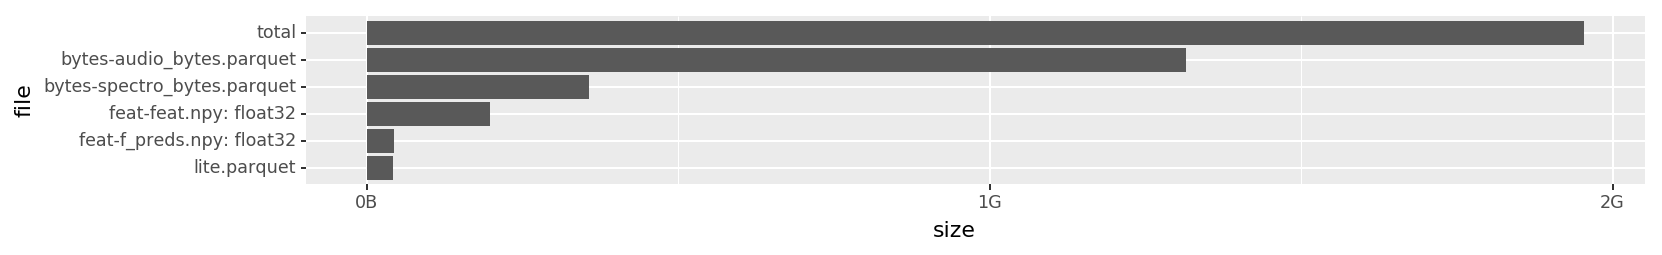

<ggplot: (345142385)>

,size,type,0
xc_id,36,int,413174
feat,6104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


search_recs(**{'cache_type': 'hybrid'})

INFO     [14:28:57.483] [21788] 601 api.recs/get_search_recs

INFO     [14:28:57.512] [21788] 144 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[4],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-7993b24

DEBUG    [14:28:57.519] [21788] 145 payloads/df_cache_hybrid: Hit [start]

INFO     [14:28:59.082] [21788] 161 payloads/df_cache_hybrid: Hit: Read lite.parquet (45.6 MB)

INFO     [14:29:04.337] [21788] 174 payloads/df_cache_hybrid: Hit: Read bytes-audio_bytes.parquet (1.4 GB)

INFO     [14:29:05.154] [21788] 174 payloads/df_cache_hybrid: Hit: Read bytes-spectro_bytes.parquet (382.8 MB)

INFO     [14:29:05.201] [21788] 182 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)

INFO     [14:29:05.360] [21788] 182 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)

INFO     [14:29:05.368] [21788] 186 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [14:29:05.733] [21788] 197 payloads/df_cache_hybrid: Hit [8.214s]

,file,size
0,total,2098945907
1,bytes-audio_bytes.parquet,1412454635
2,bytes-spectro_bytes.parquet,382833212
4,feat-feat.npy: float32,211386128
3,feat-f_preds.npy: float32,46645972
0,lite.parquet,45625960


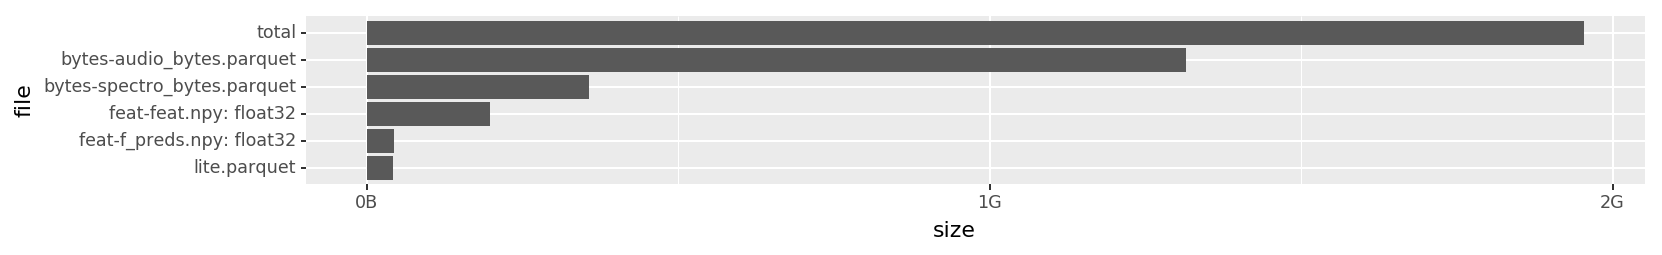

<ggplot: (-9223372036507445879)>

,size,type,0
xc_id,36,int,413174
feat,104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
log_levels({'payloads': 'INFO'})
kwargss = [
    dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for kwargs in kwargss:
    print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)